F:  [2] Q:  4079.8238363494497
F:  [2, 8] Q:  3386.767584518104
F:  [2, 8, 3] Q:  3150.400545556058
F:  [2, 8, 3, 4] Q:  3067.1077629354622
F:  [2, 8, 3, 4, 5] Q:  2993.7716019681534
F:  [2, 8, 3, 4, 5, 1] Q:  2891.1040287312344
F:  [2, 8, 3, 4, 5, 1, 0] Q:  2891.3867193172173

ADD-DEL
F best:  [2, 8, 3, 4, 5, 1]  Q best:  2891.1040287312344

FullSearch
F best:  [1, 2, 3, 4, 5, 8]  Q best:  2891.1040287312335


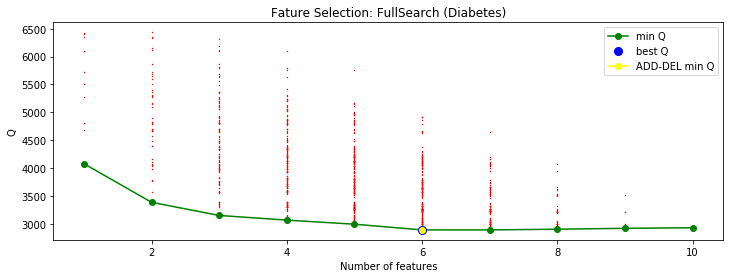

In [6]:
from sklearn import datasets
import itertools
import numpy as np
from sklearn import svm
from sklearn.linear_model import LinearRegression
import optunity
import optunity.metrics
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor as mlpr
import copy
import fullsearch
    
def Prepare_data():    
    data = datasets.load_diabetes()
    X = data.data
    y = data.target
    
    size_of_train_data = int(len(X) * 0.8)
    size_of_test_data = len(X) - size_of_train_data
    
    X_train = X[:size_of_train_data]
    y_train = y[:size_of_train_data]
    
    X_test = X[size_of_train_data:]
    y_test = y[size_of_train_data:]
    
    return X_train, y_train, X_test, y_test


class ADD_DEL:
    def __init__(self, d):
        self.d = d
     
        
    def Calc_Q(self, subset_of_features):
        X_train = self.X_train[:, subset_of_features]
        y_train = self.y_train
        
        X_test = self.X_test[:, subset_of_features]
        y_test = self.y_test
    
        model = LinearRegression()
    
        model.fit(X_train, y_train)         
        predictions = model.predict(X_test)
        
        Q = optunity.metrics.mse(y_test, predictions)
        return Q
        
    
        
    def find_feature_for_adding(self, subset_of_features):
        Q_list = []
        list_of_new_features = []
        
        for j in range(self.n):
            feature_is_free = True
            for k in range(len(subset_of_features)):
                if j == subset_of_features[k]:
                    feature_is_free = False
        
            if feature_is_free == True:
                cur_subset_of_features = copy.deepcopy(subset_of_features)
                cur_subset_of_features.append(j)
    
                Q = self.Calc_Q(cur_subset_of_features)
            
                Q_list.append(Q)
                list_of_new_features.append(j)
                
        
        index_of_min_val = Q_list.index(min(Q_list))
        return list_of_new_features[index_of_min_val]
        
    def find_feature_for_removing(self, subset_of_features):
        Q_list = []
        list_of_new_features = []
        
        for k in range(len(subset_of_features)):
            cur_subset_of_features = copy.deepcopy(subset_of_features)
            cur_subset_of_features.remove(subset_of_features[k])

            Q = self.Calc_Q(cur_subset_of_features)
        
            Q_list.append(Q)
            list_of_new_features.append(subset_of_features[k])
            
        index_of_min_val = Q_list.index(min(Q_list))
        return list_of_new_features[index_of_min_val]

        
    def fit(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        
        self.X_test = X_test
        self.y_test = y_test
        
        self.n = self.X_train.shape[1]
        
        F = []
        
        history_of_Q = []
        
        t = 0
        
        Q_best = 1E9
        F_best = []
        
        while True:
            t0 = copy.deepcopy(t)
            
            while len(F) < X_train.shape[1]:
                t += 1
            
                F_best = copy.deepcopy(F)
            
                f = self.find_feature_for_adding(F)
                F.append(f)
                
                cur_Q = self.Calc_Q(F)
                
                print('F: ', F, end = ' ')
                print('Q: ', cur_Q)
                
                history_of_Q.append(cur_Q)    
                
                needed_part_of_history = history_of_Q[t0:]
                
                Q_sharp = min(needed_part_of_history)
                
                if Q_sharp >= Q_best:
                    return F_best, Q_best
                
                Q_best = Q_sharp
                
                iteration_of_the_best_subset = needed_part_of_history.index(Q_sharp)
                
                if t-t0 - iteration_of_the_best_subset >= self.d:
                    break
                
                
            t0 = copy.deepcopy(t)
            
            while len(F) > 0:
                t += 1
            
                F_best = copy.deepcopy(F)
            
                f = self.find_feature_for_removing(F)
                F.remove(f)
                
                cur_Q = self.Calc_Q(F)
                
                print('F: ', F, end = ' ')
                print('Q: ', cur_Q)
                
                history_of_Q.append(cur_Q)    
                
                
                needed_part_of_history = history_of_Q[t0:]
                 
                Q_sharp = min(needed_part_of_history)
                
                if Q_sharp >= Q_best:
                    return F_best, Q_best
                
                Q_best = Q_sharp
                
                iteration_of_the_best_subset = needed_part_of_history.index(Q_sharp)
            
                if t-t0 - iteration_of_the_best_subset >= self.d:
                    break
            
            
add_del = ADD_DEL(d = 3)          
X_train, y_train, X_test, y_test = Prepare_data()  
best_feature_subset, Q_best = add_del.fit(X_train, y_train, X_test, y_test)

print()
print('ADD-DEL') 
print('F best: ', best_feature_subset, ' Q best: ', Q_best)

best_feature_subset, Q_best, plt = fullsearch.Full_Search(X_train, y_train, X_test, y_test)  

print()
print('FullSearch')
print('F best: ', best_feature_subset, ' Q best: ', Q_best)

plt.plot(len(best_feature_subset), Q_best, 'ro-', color = 'yellow', label = 'ADD-DEL min Q')
plt.legend()
plt.rcParams["figure.figsize"] = (12, 4)
plt.show()